In [74]:
from imp import reload
from nltk.corpus import stopwords
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib as mpl
import nltk,re,pprint
import sys,glob,os
import operator, string, argparse, math, random
import matplotlib.pyplot as plot

In [98]:
class flingPretrained:
    def __init__(self,data):
        self.data = data
        self.nDocs = len(self.data)
        self.allDistances = {}
        self.wordVecModel = None
        print("\nDBSCAN initialized!\n")
        
    def loadPretrainedWordVectors(self,vecType):
        if vecType == 'glove':
            self.wordVecModel = self.loadGloveModel()
            print("GloVe Vectors Loaded!\n")

    def loadGloveModel(self):
        print("Loading Glove Model\n")
        f = open('../datasets/glove.6B/glove.6B.50d.txt','r')
        gloveModel = {}
        for line in f:
            splitLines = line.split()
            word = splitLines[0]
            wordEmbedding = np.array([float(value) for value in splitLines[1:]])
            gloveModel[word] = wordEmbedding
        print(len(gloveModel)," words loaded!\n")
        return gloveModel
    
    def getDocVector(self,doc_Id):
        gvl=self.getGloveVectorList(listx)
        glove_dv = np.mean(gvl,axis=0)
        return(glove_dv)
    
    def addDocumentGloveVector(self):
        vecL = []
        for indx in range(self.nDocs):
            listWords_1 = set(list(self.data['tfMatrix'][int(indx)]['word']))
            gvl=self.getGloveVectorList(listWords_1)
            vecL.append(np.mean(gvl,axis=0))
        self.data['glove-vector'] = vecL

    # distance between two documents using TF-IDF
    def distanceBtnTwoDocs(self, docId_1, docId_2):
        listWords_1 = set(list(self.data['tfMatrix'][int(docId_1)]['word']))
        listWords_2 = set(list(self.data['tfMatrix'][int(docId_2)]['word']))
        common = listWords_1.intersection(listWords_2)
        diff1_2 = listWords_1.difference(listWords_2)
        diff2_1 = listWords_2.difference(listWords_1)
        sumwt1 = self.data['sumTFIDF'][docId_1]
        sumwt2 = self.data['sumTFIDF'][docId_2]
        score_common, score_doc1, score_doc2 = 0,0,0
        #print(len(common),len(diff1_2),len(diff2_1))
        for word_c in common:
            score_1 = float(self.data['tfMatrix'][docId_1].loc[self.data['tfMatrix'][docId_1]['word'] == word_c]['tf-idf'])
            score_2 = float(self.data['tfMatrix'][docId_2].loc[self.data['tfMatrix'][docId_2]['word'] == word_c]['tf-idf'])
            score_common += abs(score_1/float(sumwt1) - score_2/float(sumwt2))
        for word_d12 in diff1_2:
            score_1 = float(self.data['tfMatrix'][docId_1].loc[self.data['tfMatrix'][docId_1]['word'] == word_d12]['tf-idf'])
            score_doc1 += score_1/float(sumwt1)
        for word_d21 in diff2_1:
            score_2 = float(self.data['tfMatrix'][docId_2].loc[self.data['tfMatrix'][docId_2]['word'] == word_d21]['tf-idf'])
            score_doc2 += score_2/float(sumwt2)
        score_total = score_common + score_doc1 + score_doc2
        return(score_total)
    
    def getGloveVectorList(self,listx):
        vecList = []
        nf = []
        for w in listx:
            try:
                vecList.append(self.wordVecModel[w])
            except:
                nf.append(w)
                #print(w,"not found in glove model!")
                continue        
        if len(vecList)==0:
            return([[0]*50])
        vecArray = np.stack(vecList, axis=0 )
        return vecArray
    
    def getDocVector(self,listx):
        gvl=self.getGloveVectorList(listx)
        glove_dv = np.mean(gvl,axis=0)
        return(glove_dv)
    
    def getGloveDistance(self,docId_1,docId_2,method):
        listWords_1 = set(list(self.data['tfMatrix'][int(docId_1)]['word']))
        listWords_2 = set(list(self.data['tfMatrix'][int(docId_2)]['word']))
        if method == 'average':
            dv_1 = self.getDocVector(listWords_1)
            dv_2 = self.getDocVector(listWords_2)
            #print("dv_1",dv_1)
            #print("dv_2",dv_2)
            dist = np.linalg.norm(dv_1-dv_2)
            return dist
              
    def drawProgressBar(self, percent, barLen = 50):			#just a progress bar so that you dont lose patience
        sys.stdout.write("\r")
        progress = ""
        for i in range(barLen):
            if i<int(barLen * percent):
                progress += "="
            else:
                progress += " "
        sys.stdout.write("[ %s ] %.2f%%" % (progress, percent * 100))
        sys.stdout.flush()	

    #sample distance between n random documents 
    def getDistanceDistribution(self,numx):
        numHalf = int(numx/2)
        doca,docb = [],[]
        for i in range(numHalf):
            doca.append(random.randint(1,1026))
            docb.append(random.randint(1027,2053))
        distanceSample = []
        total = numHalf*numHalf
        for doc_1 in range(len(doca)):
            for doc_2 in range(len(docb)):
                distanceSample.append(self.getGloveDistance(doca[doc_1],docb[doc_2],'average'))
                cov = doc_1*numHalf + doc_2
                prog=(cov+1)/total
                self.drawProgressBar(prog)
        pltx = plot.hist(distanceSample,bins=20)
        return(pltx)
    
    def doctfidf2vec(self,docId,mode):
        listWords = list(self.data['tfMatrix'][int(docId)]['word'])
        if mode == "tf-only":
            scores = list(self.data['tfMatrix'][int(docId)]['tf'])
        elif mode == "tf-idf":
            scores = list(self.data['tfMatrix'][int(docId)]['tf-idf'])
        lenW =len(listWords)
        vecList = []
        for w in range(lenW):
            xword = listWords[w]
            xscore = scores[w]
            try:
                vecList.append(xscore*self.wordVecModel[xword])
            except:
                continue
        if len(vecList)==0:
            return([[0]*50])
        vecArray = np.stack(vecList, axis=0)
        return(np.mean(vecArray,axis=0))
    
    def tfidf2vec(self,mode):
        vecL = []
        if mode == 'tf-only':
            columnName = 'tfidf2vec-tf'
            for indx in range(self.nDocs):
                gvl=self.doctfidf2vec(indx,'tf-only')
                vecL.append(gvl)
        else:
            columnName = 'tfidf2vec-tfidf'
            for indx in range(self.nDocs):
                gvl=self.doctfidf2vec(indx,'tf-idf')
                vecL.append(gvl)            
        self.data[columnName] = vecL

In [99]:
dataProcessed = pd.read_pickle('../processFiles/data_tfidf_processed.pkl')
fdb = flingPretrained(dataProcessed)
fdb.loadPretrainedWordVectors('glove')
fdb.addDocumentGloveVector()


DBSCAN initialized!

Loading Glove Model

400000  words loaded!

GloVe Vectors Loaded!



In [100]:
fdb.tfidf2vec('tf-only')
fdb.tfidf2vec('tf-idf')

In [101]:
fdb.data

,Job Description,Company Name,Industry,stopsRemoved,tfMatrix,sumTFIDF,glove-vector,tfidf2vec-tf,tfidf2vec-tfidf
0,Are you eager to roll up your sleeves and harn...,Vera Institute of Justice\n3.2,Social Assistance,eager roll sleeves harness data drive policy c...,word tf tf-idf 0 data...,811.569328,"[0.20507256798029552, 0.0598494995073891, 0.01...","[0.2986073091133004, 0.05040200935960588, 0.09...","[0.26263354824176166, -0.023444644206149418, -..."
1,Overview\n\nProvides analytical and technical ...,Visiting Nurse Service of New York\n3.8,Health Care Services & Hospitals,overview provides analytical technical support...,word tf tf-idf 0 dat...,415.287583,"[0.23643422682926826, -0.05505695731707317, 0....","[0.4055475764227641, -0.07285501829268287, 0.1...","[0.35240058786555273, -0.1412004425681622, 0.0..."
2,Weâre looking for a Senior Data Analyst who ...,Squarespace\n3.4,Internet,weâre looking senior data analyst love mento...,word tf tf-idf 0 data ...,439.815932,"[0.1558613515769231, 0.1173542546153847, -0.05...","[0.283220747730769, 0.14354892653846157, 0.044...","[0.2563749918506738, 0.17575736117618113, -0.0..."
3,Requisition NumberRR-0001939\nRemote:Yes\nWe c...,Celerity\n4.1,IT Services,requisition numberrr remoteyes collaborate cre...,word tf tf-idf 0 â¢ ...,569.217931,"[0.23067398808139536, 0.0934725453488372, -0.0...","[0.29634610203488354, 0.10983982558139535, 0.0...","[0.2966705423736133, 0.028126685382837024, -0...."
4,ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,FanDuel\n3.9,Sports & Recreation,fanduel group fanduel group worldclass team br...,word tf tf-idf 0 fanduel...,420.106719,"[0.1291470720183486, 0.11582829587155967, 0.04...","[0.17368260871559627, 0.10919291513761473, 0.0...","[0.021771101166884813, 0.16355587986765768, -0..."
...,...,...,...,...,...,...,...,...,...
2248,Maintains systems to protect data from unautho...,"Avacend, Inc.\n2.5",Staffing & Outsourcing,maintains systems protect data unauthorized us...,word tf tf-idf 0 ...,43.940807,"[0.27380813157894734, -0.0012553210526315862, ...","[0.2949110263157894, 0.029555310526315794, 0.0...","[0.23112386279259817, -0.08318866123802247, -0..."
2249,Position:\nSenior Data Analyst (Corporate Audi...,Arrow Electronics\n2.9,Wholesale,position senior data analyst corporate audit j...,word tf tf-idf 0 ...,439.042957,"[0.22004683554817292, 0.10710706677740861, 0.0...","[0.3396034966777404, 0.09931764750830561, 0.09...","[0.3077493047461843, 0.06387599003189207, 0.06..."
2250,"Title: Technical Business Analyst (SQL, Data a...",Spiceorb,-1,title technical business analyst sql data anal...,word tf tf-idf 0 busin...,205.978695,"[0.3618827105263159, 0.05400915065789475, 0.04...","[0.5060029144736842, 0.04490494473684211, 0.11...","[0.45506833532863533, 5.3025424212786644e-05, ..."
2251,Summary\n\nResponsible for working cross-funct...,Contingent Network Services\n3.1,Enterprise Software & Network Solutions,summary responsible working crossfunctionally ...,word tf tf-idf 0 ...,364.177527,"[0.25247974618181823, 0.07676844581818176, -0....","[0.34654995709090924, 0.07137524545454547, 0.0...","[0.27937433353352015, 0.08437047685035409, -0...."


[ ================================================== ] 100.00%

(array([  2.,   0.,  27., 195., 430., 455., 403., 395., 266., 134.,  67.,
         42.,  20.,  12.,   9.,  10.,  21.,   8.,   1.,   3.]),
 array([0.08832741, 0.18676094, 0.28519447, 0.383628  , 0.48206153,
        0.58049506, 0.67892858, 0.77736211, 0.87579564, 0.97422917,
        1.0726627 , 1.17109623, 1.26952975, 1.36796328, 1.46639681,
        1.56483034, 1.66326387, 1.7616974 , 1.86013092, 1.95856445,
        2.05699798]),
 <BarContainer object of 20 artists>)

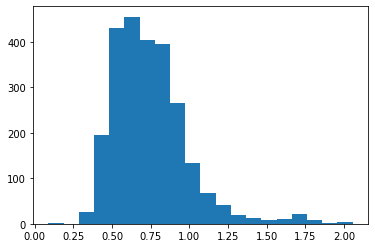

In [60]:
fdb.getDistanceDistribution(100)

[ ================================================== ] 100.00%

(array([   5.,    0.,    5.,  159.,  806., 1781., 2065., 1699., 1128.,
         796.,  562.,  412.,  280.,  141.,   99.,   31.,   18.,    7.,
           0.,    6.]),
 array([0.        , 0.0951702 , 0.19034041, 0.28551061, 0.38068082,
        0.47585102, 0.57102122, 0.66619143, 0.76136163, 0.85653184,
        0.95170204, 1.04687224, 1.14204245, 1.23721265, 1.33238286,
        1.42755306, 1.52272326, 1.61789347, 1.71306367, 1.80823388,
        1.90340408]),
 <BarContainer object of 20 artists>)

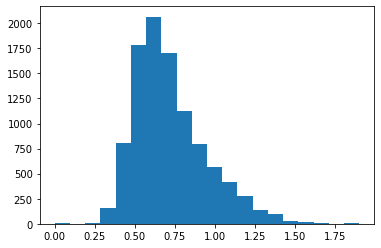

In [61]:
fdb.getDistanceDistribution(200)

[ ================================================== ] 100.00%

(array([5.5000e+01, 0.0000e+00, 2.2600e+02, 4.4460e+03, 1.3129e+04,
        1.6116e+04, 1.2372e+04, 7.4690e+03, 3.8440e+03, 2.2510e+03,
        1.1180e+03, 5.7400e+02, 3.8600e+02, 1.6200e+02, 9.5000e+01,
        9.5000e+01, 1.2100e+02, 3.0000e+01, 9.0000e+00, 2.0000e+00]),
 array([0.        , 0.11873617, 0.23747233, 0.3562085 , 0.47494466,
        0.59368083, 0.71241699, 0.83115316, 0.94988932, 1.06862549,
        1.18736165, 1.30609782, 1.42483398, 1.54357015, 1.66230631,
        1.78104248, 1.89977864, 2.01851481, 2.13725097, 2.25598714,
        2.3747233 ]),
 <BarContainer object of 20 artists>)

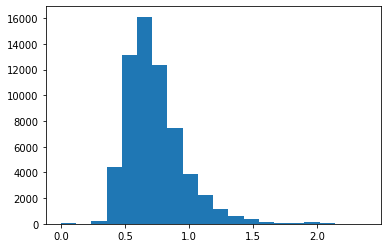

In [62]:
fdb.getDistanceDistribution(500)